In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler
import os

In [2]:
df1=pd.read_csv("database.csv")

In [3]:
Y = df1.iloc[:,25:28]
X = df1.iloc[:,:8]
Y.head()

,q_abs,q_sca,g
0,0.11691,0.000389,0.003798
1,0.15300,0.001005,0.008979
2,0.20060,0.002514,0.022970
3,0.23162,0.004187,0.037044
4,0.25746,0.005988,0.051049


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=0.25, 
        random_state=42)
Y_train.shape

(7370, 3)

In [8]:
#With MinMaxScaler

In [9]:
scaling_x=StandardScaler()
#scaling_y=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.transform(X_test)
#Y_train=scaling_y.fit_transform(Y_train)

In [10]:
NN_model1 = Sequential()

# The Input Layer :
NN_model1.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model1.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model1.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model1.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model1.add(Dense(3, kernel_initializer='normal',activation='linear'))
# Compile the network :
NN_model1.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['accuracy'])
NN_model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 771       
Total params: 166,531
Trainable params: 166,531
Non-trainable params: 0
_________________________________________________________________


In [11]:
filepath="random_split_with_min_max/Weights-{epoch:03d}--{val_loss:.5f}.hdf5"

checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

In [12]:
# # patient early stopping
es = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [13]:
log_csv=CSVLogger('random_split_with_min_max_loss_logs.csv', separator=',', append=False)

In [14]:
callback_list=[checkpoint, es, log_csv]

In [15]:
history1= NN_model1.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callback_list)
#history= NN_model.fit(X_train, Y_train, epochs=7, batch_size=32, validation_split = 0.2)

Epoch 1/500
182/185 [============================>.] - ETA: 0s - loss: 39.6091 - accuracy: 0.8829  
Epoch 00001: val_loss improved from inf to 19.44829, saving model to random_split_with_min_max\Weights-001--19.44829.hdf5
185/185 [==============================] - 0s 3ms/step - loss: 39.2964 - accuracy: 0.8835 - val_loss: 19.4483 - val_accuracy: 0.9600
Epoch 2/500
163/185 [=========================>....] - ETA: 0s - loss: 10.6626 - accuracy: 0.9726
Epoch 00002: val_loss improved from 19.44829 to 18.09565, saving model to random_split_with_min_max\Weights-002--18.09565.hdf5
185/185 [==============================] - 0s 2ms/step - loss: 10.6001 - accuracy: 0.9739 - val_loss: 18.0957 - val_accuracy: 0.9824
Epoch 3/500
173/185 [===========================>..] - ETA: 0s - loss: 9.9132 - accuracy: 0.9830
Epoch 00003: val_loss improved from 18.09565 to 9.24200, saving model to random_split_with_min_max\Weights-003--9.24200.hdf5
185/185 [==============================] - 0s 2ms/step - loss: 9.

Epoch 28/500
164/185 [=========================>....] - ETA: 0s - loss: 3.9021 - accuracy: 0.9907
Epoch 00028: val_loss did not improve from 3.17729
185/185 [==============================] - 0s 1ms/step - loss: 3.9711 - accuracy: 0.9908 - val_loss: 5.1540 - val_accuracy: 0.9810
Epoch 29/500
176/185 [===========================>..] - ETA: 0s - loss: 4.1692 - accuracy: 0.9901
Epoch 00029: val_loss did not improve from 3.17729
185/185 [==============================] - 0s 1ms/step - loss: 4.1671 - accuracy: 0.9903 - val_loss: 4.3692 - val_accuracy: 0.9912
Epoch 30/500
180/185 [============================>.] - ETA: 0s - loss: 3.6791 - accuracy: 0.9903
Epoch 00030: val_loss did not improve from 3.17729
185/185 [==============================] - 0s 1ms/step - loss: 3.6727 - accuracy: 0.9905 - val_loss: 3.7998 - val_accuracy: 0.9898
Epoch 31/500
178/185 [===========================>..] - ETA: 0s - loss: 4.0920 - accuracy: 0.9898
Epoch 00031: val_loss did not improve from 3.17729
185/185 [==

Epoch 57/500
184/185 [============================>.] - ETA: 0s - loss: 3.1328 - accuracy: 0.9898
Epoch 00057: val_loss did not improve from 2.84131
185/185 [==============================] - 0s 1ms/step - loss: 3.1403 - accuracy: 0.9898 - val_loss: 4.0826 - val_accuracy: 0.9953
Epoch 58/500
182/185 [============================>.] - ETA: 0s - loss: 3.3219 - accuracy: 0.9904
Epoch 00058: val_loss improved from 2.84131 to 2.79651, saving model to random_split_with_min_max\Weights-058--2.79651.hdf5
185/185 [==============================] - 0s 1ms/step - loss: 3.3188 - accuracy: 0.9905 - val_loss: 2.7965 - val_accuracy: 0.9932
Epoch 59/500
143/185 [======================>.......] - ETA: 0s - loss: 3.2051 - accuracy: 0.9913
Epoch 00059: val_loss did not improve from 2.79651
185/185 [==============================] - 0s 1ms/step - loss: 3.1633 - accuracy: 0.9915 - val_loss: 3.6634 - val_accuracy: 0.9919
Epoch 60/500
181/185 [============================>.] - ETA: 0s - loss: 3.1646 - accura

Epoch 85/500
184/185 [============================>.] - ETA: 0s - loss: 2.7521 - accuracy: 0.9927
Epoch 00085: val_loss did not improve from 2.54269
185/185 [==============================] - 0s 1ms/step - loss: 2.7577 - accuracy: 0.9927 - val_loss: 5.1058 - val_accuracy: 0.9878
Epoch 86/500
177/185 [===========================>..] - ETA: 0s - loss: 3.0188 - accuracy: 0.9913
Epoch 00086: val_loss did not improve from 2.54269
185/185 [==============================] - 0s 1ms/step - loss: 3.0111 - accuracy: 0.9917 - val_loss: 3.8199 - val_accuracy: 0.9973
Epoch 87/500
142/185 [======================>.......] - ETA: 0s - loss: 2.8553 - accuracy: 0.9923
Epoch 00087: val_loss did not improve from 2.54269
185/185 [==============================] - 0s 1ms/step - loss: 2.8077 - accuracy: 0.9924 - val_loss: 2.8235 - val_accuracy: 0.9939
Epoch 88/500
184/185 [============================>.] - ETA: 0s - loss: 2.6470 - accuracy: 0.9935
Epoch 00088: val_loss did not improve from 2.54269
185/185 [==

Epoch 142/500
183/185 [============================>.] - ETA: 0s - loss: 2.6962 - accuracy: 0.9954
Epoch 00142: val_loss did not improve from 2.12417
185/185 [==============================] - 0s 1ms/step - loss: 2.7009 - accuracy: 0.9953 - val_loss: 2.5942 - val_accuracy: 0.9953
Epoch 143/500
176/185 [===========================>..] - ETA: 0s - loss: 2.9516 - accuracy: 0.9940
Epoch 00143: val_loss did not improve from 2.12417
185/185 [==============================] - 0s 1ms/step - loss: 2.9677 - accuracy: 0.9941 - val_loss: 3.2732 - val_accuracy: 0.9953
Epoch 144/500
178/185 [===========================>..] - ETA: 0s - loss: 2.5895 - accuracy: 0.9932
Epoch 00144: val_loss did not improve from 2.12417
185/185 [==============================] - 0s 1ms/step - loss: 2.5895 - accuracy: 0.9934 - val_loss: 3.1406 - val_accuracy: 0.9953
Epoch 145/500
175/185 [===========================>..] - ETA: 0s - loss: 2.5895 - accuracy: 0.9934
Epoch 00145: val_loss did not improve from 2.12417
185/185

Epoch 200/500
173/185 [===========================>..] - ETA: 0s - loss: 2.3771 - accuracy: 0.9953
Epoch 00200: val_loss did not improve from 1.92550
185/185 [==============================] - 0s 1ms/step - loss: 2.3471 - accuracy: 0.9956 - val_loss: 1.9515 - val_accuracy: 0.9959
Epoch 201/500
183/185 [============================>.] - ETA: 0s - loss: 2.4237 - accuracy: 0.9949
Epoch 00201: val_loss improved from 1.92550 to 1.83804, saving model to random_split_with_min_max\Weights-201--1.83804.hdf5
185/185 [==============================] - 0s 1ms/step - loss: 2.4219 - accuracy: 0.9949 - val_loss: 1.8380 - val_accuracy: 0.9946
Epoch 202/500
171/185 [==========================>...] - ETA: 0s - loss: 2.2635 - accuracy: 0.9967
Epoch 00202: val_loss did not improve from 1.83804
185/185 [==============================] - 0s 1ms/step - loss: 2.2507 - accuracy: 0.9966 - val_loss: 2.2353 - val_accuracy: 0.9986
Epoch 203/500
178/185 [===========================>..] - ETA: 0s - loss: 2.4482 - ac

Epoch 229/500
179/185 [============================>.] - ETA: 0s - loss: 2.4157 - accuracy: 0.9949
Epoch 00229: val_loss did not improve from 1.83804
185/185 [==============================] - 0s 1ms/step - loss: 2.4187 - accuracy: 0.9951 - val_loss: 3.5941 - val_accuracy: 0.9932
Epoch 230/500
180/185 [============================>.] - ETA: 0s - loss: 2.3543 - accuracy: 0.9946
Epoch 00230: val_loss did not improve from 1.83804
185/185 [==============================] - 0s 1ms/step - loss: 2.3727 - accuracy: 0.9947 - val_loss: 3.2088 - val_accuracy: 0.9946
Epoch 231/500
175/185 [===========================>..] - ETA: 0s - loss: 2.2986 - accuracy: 0.9943
Epoch 00231: val_loss did not improve from 1.83804
185/185 [==============================] - 0s 1ms/step - loss: 2.2793 - accuracy: 0.9946 - val_loss: 3.2114 - val_accuracy: 0.9966
Epoch 232/500
179/185 [============================>.] - ETA: 0s - loss: 2.1208 - accuracy: 0.9955
Epoch 00232: val_loss did not improve from 1.83804
185/185

Epoch 287/500
182/185 [============================>.] - ETA: 0s - loss: 2.3303 - accuracy: 0.9955
Epoch 00287: val_loss did not improve from 1.82851
185/185 [==============================] - 0s 1ms/step - loss: 2.3205 - accuracy: 0.9954 - val_loss: 2.5777 - val_accuracy: 0.9980
Epoch 288/500
176/185 [===========================>..] - ETA: 0s - loss: 2.1652 - accuracy: 0.9949
Epoch 00288: val_loss did not improve from 1.82851
185/185 [==============================] - 0s 1ms/step - loss: 2.1568 - accuracy: 0.9946 - val_loss: 1.8821 - val_accuracy: 0.9980
Epoch 289/500
183/185 [============================>.] - ETA: 0s - loss: 2.1211 - accuracy: 0.9956
Epoch 00289: val_loss did not improve from 1.82851
185/185 [==============================] - 0s 1ms/step - loss: 2.1322 - accuracy: 0.9956 - val_loss: 2.4701 - val_accuracy: 0.9953
Epoch 290/500
179/185 [============================>.] - ETA: 0s - loss: 2.4509 - accuracy: 0.9944
Epoch 00290: val_loss did not improve from 1.82851
185/185

Epoch 316/500
176/185 [===========================>..] - ETA: 0s - loss: 1.9934 - accuracy: 0.9959
Epoch 00316: val_loss did not improve from 1.74023
185/185 [==============================] - 0s 1ms/step - loss: 1.9848 - accuracy: 0.9959 - val_loss: 2.1754 - val_accuracy: 0.9946
Epoch 317/500
179/185 [============================>.] - ETA: 0s - loss: 2.1658 - accuracy: 0.9941
Epoch 00317: val_loss did not improve from 1.74023
185/185 [==============================] - 0s 1ms/step - loss: 2.1640 - accuracy: 0.9939 - val_loss: 2.2525 - val_accuracy: 0.9959
Epoch 318/500
182/185 [============================>.] - ETA: 0s - loss: 2.0190 - accuracy: 0.9948
Epoch 00318: val_loss did not improve from 1.74023
185/185 [==============================] - 0s 1ms/step - loss: 2.0191 - accuracy: 0.9947 - val_loss: 2.0552 - val_accuracy: 0.9946
Epoch 319/500
178/185 [===========================>..] - ETA: 0s - loss: 2.3176 - accuracy: 0.9951
Epoch 00319: val_loss did not improve from 1.74023
185/185

Epoch 345/500
174/185 [===========================>..] - ETA: 0s - loss: 2.0031 - accuracy: 0.9959
Epoch 00345: val_loss did not improve from 1.72667
185/185 [==============================] - 0s 1ms/step - loss: 2.0161 - accuracy: 0.9958 - val_loss: 2.2801 - val_accuracy: 0.9946
Epoch 346/500
177/185 [===========================>..] - ETA: 0s - loss: 2.1427 - accuracy: 0.9966
Epoch 00346: val_loss did not improve from 1.72667
185/185 [==============================] - 0s 1ms/step - loss: 2.1402 - accuracy: 0.9961 - val_loss: 2.1081 - val_accuracy: 0.9966
Epoch 347/500
179/185 [============================>.] - ETA: 0s - loss: 1.9950 - accuracy: 0.9960
Epoch 00347: val_loss did not improve from 1.72667
185/185 [==============================] - 0s 1ms/step - loss: 1.9833 - accuracy: 0.9961 - val_loss: 1.9180 - val_accuracy: 0.9986
Epoch 348/500
177/185 [===========================>..] - ETA: 0s - loss: 2.1353 - accuracy: 0.9956
Epoch 00348: val_loss did not improve from 1.72667
185/185

179/185 [============================>.] - ETA: 0s - loss: 1.7931 - accuracy: 0.9953
Epoch 00403: val_loss improved from 1.72667 to 1.72405, saving model to random_split_with_min_max\Weights-403--1.72405.hdf5
185/185 [==============================] - 0s 2ms/step - loss: 1.8124 - accuracy: 0.9954 - val_loss: 1.7240 - val_accuracy: 0.9973
Epoch 404/500
179/185 [============================>.] - ETA: 0s - loss: 1.9667 - accuracy: 0.9956
Epoch 00404: val_loss did not improve from 1.72405
185/185 [==============================] - 0s 1ms/step - loss: 1.9709 - accuracy: 0.9958 - val_loss: 2.1980 - val_accuracy: 0.9973
Epoch 405/500
177/185 [===========================>..] - ETA: 0s - loss: 2.0652 - accuracy: 0.9963
Epoch 00405: val_loss did not improve from 1.72405
185/185 [==============================] - 0s 1ms/step - loss: 2.0513 - accuracy: 0.9964 - val_loss: 2.6826 - val_accuracy: 0.9973
Epoch 406/500
177/185 [===========================>..] - ETA: 0s - loss: 1.9769 - accuracy: 0.9949

Epoch 432/500
175/185 [===========================>..] - ETA: 0s - loss: 2.0214 - accuracy: 0.9962
Epoch 00432: val_loss did not improve from 1.57701
185/185 [==============================] - 0s 1ms/step - loss: 2.0182 - accuracy: 0.9963 - val_loss: 2.1411 - val_accuracy: 0.9980
Epoch 433/500
177/185 [===========================>..] - ETA: 0s - loss: 1.9497 - accuracy: 0.9961
Epoch 00433: val_loss did not improve from 1.57701
185/185 [==============================] - 0s 1ms/step - loss: 1.9430 - accuracy: 0.9959 - val_loss: 1.6654 - val_accuracy: 0.9973
Epoch 434/500
181/185 [============================>.] - ETA: 0s - loss: 2.1140 - accuracy: 0.9948
Epoch 00434: val_loss did not improve from 1.57701
185/185 [==============================] - 0s 1ms/step - loss: 2.1115 - accuracy: 0.9949 - val_loss: 2.5182 - val_accuracy: 0.9980
Epoch 435/500
179/185 [============================>.] - ETA: 0s - loss: 2.0105 - accuracy: 0.9960
Epoch 00435: val_loss did not improve from 1.57701
185/185

Epoch 490/500
178/185 [===========================>..] - ETA: 0s - loss: 1.7981 - accuracy: 0.9951
Epoch 00490: val_loss did not improve from 1.53014
185/185 [==============================] - 0s 1ms/step - loss: 1.8080 - accuracy: 0.9953 - val_loss: 2.0019 - val_accuracy: 0.9946
Epoch 491/500
178/185 [===========================>..] - ETA: 0s - loss: 1.6434 - accuracy: 0.9953
Epoch 00491: val_loss did not improve from 1.53014
185/185 [==============================] - 0s 1ms/step - loss: 1.6422 - accuracy: 0.9954 - val_loss: 1.8307 - val_accuracy: 0.9973
Epoch 492/500
185/185 [==============================] - ETA: 0s - loss: 1.7896 - accuracy: 0.9947
Epoch 00492: val_loss did not improve from 1.53014
185/185 [==============================] - 0s 1ms/step - loss: 1.7896 - accuracy: 0.9947 - val_loss: 1.8184 - val_accuracy: 0.9966
Epoch 493/500
176/185 [===========================>..] - ETA: 0s - loss: 1.8874 - accuracy: 0.9961
Epoch 00493: val_loss did not improve from 1.53014
185/185

In [16]:
NN_model1.save('random_split_with_min_max.h5')

Train loss: 2.470, Validation loss: 2.745


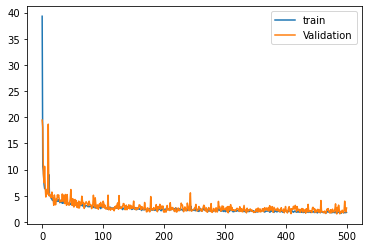

In [17]:
# evaluate the model
train_loss, train_acc = NN_model1.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = NN_model1.evaluate(X_test, Y_test, verbose=0)
print('Train loss: %.3f, Validation loss: %.3f' % (train_loss, test_loss))
# plot training history
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [18]:
weights_file = 'random_split_with_min_max/Weights-484--1.53014.hdf5' # choose the best checkpoint 
NN_model1.load_weights(weights_file) # load it
NN_model1.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [19]:
Y_pred = NN_model1.predict(X_test)
#Y_pred=scaling_y.inverse_transform(Y_pred)

In [20]:
error= mean_absolute_percentage_error(Y_test, Y_pred, multioutput='raw_values')   
print('Mean absolute percentage error on test set: ', error)

Mean absolute percentage error on test set:  [0.00867443 0.02003537 0.01888168]


In [8]:
#Leave fractal dimesion=2.2 as test set

In [9]:
#With MinMaxScaler

In [4]:
train_set=df1[(df1['fractal_dimension']<=2.1) | (df1['fractal_dimension']>2.2)]
test_set=df1[df1['fractal_dimension']==2.2]
test_set.shape

(2195, 36)

In [5]:
Y_train = train_set.iloc[:,25:28]
X_train = train_set.iloc[:,:8]
Y_test = test_set.iloc[:,25:28]
X_test = test_set.iloc[:,:8]

In [6]:
scaling_x=StandardScaler()
#scaling_y=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.transform(X_test)
#Y_train=scaling_y.fit_transform(Y_train)

In [7]:
NN_model2 = Sequential()

# The Input Layer :
NN_model2.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model2.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model2.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model2.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model2.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model2.add(Dense(128, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model2.add(Dense(3, kernel_initializer='normal',activation='linear'))


# Compile the network :
NN_model2.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['accuracy'])
NN_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3

In [8]:
filepath="fractal_dimension_2_2_with_min_max/Weights-{epoch:03d}--{val_loss:.5f}.hdf5"

checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

In [9]:
# # patient early stopping
es = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [10]:
log_csv=CSVLogger('fractal_dimension_2_2_with_min_max_loss_logs.csv', separator=',', append=False)

In [11]:
callback_list=[checkpoint, es, log_csv]

In [12]:
history2= NN_model2.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callback_list)
#history= NN_model.fit(X_train, Y_train, epochs=7, batch_size=32, validation_split = 0.2)

Epoch 1/500
178/191 [==========================>...] - ETA: 0s - loss: 36.1134 - accuracy: 0.8415
Epoch 00001: val_loss improved from inf to 19.04614, saving model to fractal_dimension_2_2_with_min_max\Weights-001--19.04614.hdf5
191/191 [==============================] - 1s 3ms/step - loss: 34.6997 - accuracy: 0.8480 - val_loss: 19.0461 - val_accuracy: 0.9646
Epoch 2/500
162/191 [========================>.....] - ETA: 0s - loss: 10.0928 - accuracy: 0.9718
Epoch 00002: val_loss improved from 19.04614 to 14.94230, saving model to fractal_dimension_2_2_with_min_max\Weights-002--14.94230.hdf5
191/191 [==============================] - 0s 2ms/step - loss: 9.9040 - accuracy: 0.9730 - val_loss: 14.9423 - val_accuracy: 0.9823
Epoch 3/500
167/191 [=========================>....] - ETA: 0s - loss: 8.1194 - accuracy: 0.9820
Epoch 00003: val_loss improved from 14.94230 to 10.60093, saving model to fractal_dimension_2_2_with_min_max\Weights-003--10.60093.hdf5
191/191 [==============================

Epoch 00028: val_loss did not improve from 5.61374
191/191 [==============================] - 0s 2ms/step - loss: 4.3065 - accuracy: 0.9889 - val_loss: 8.2193 - val_accuracy: 0.9954
Epoch 29/500
185/191 [============================>.] - ETA: 0s - loss: 4.0376 - accuracy: 0.9887
Epoch 00029: val_loss did not improve from 5.61374
191/191 [==============================] - 0s 2ms/step - loss: 4.0449 - accuracy: 0.9884 - val_loss: 8.4176 - val_accuracy: 0.9908
Epoch 30/500
179/191 [===========================>..] - ETA: 0s - loss: 4.2646 - accuracy: 0.9857
Epoch 00030: val_loss did not improve from 5.61374
191/191 [==============================] - 0s 2ms/step - loss: 4.2489 - accuracy: 0.9859 - val_loss: 8.8579 - val_accuracy: 0.9921
Epoch 31/500
178/191 [==========================>...] - ETA: 0s - loss: 4.3136 - accuracy: 0.9877
Epoch 00031: val_loss did not improve from 5.61374
191/191 [==============================] - 0s 2ms/step - loss: 4.3813 - accuracy: 0.9882 - val_loss: 7.0148 -

190/191 [============================>.] - ETA: 0s - loss: 3.6603 - accuracy: 0.9908
Epoch 00057: val_loss improved from 5.52249 to 5.48492, saving model to fractal_dimension_2_2_with_min_max\Weights-057--5.48492.hdf5
191/191 [==============================] - 0s 2ms/step - loss: 3.6611 - accuracy: 0.9908 - val_loss: 5.4849 - val_accuracy: 0.9928
Epoch 58/500
165/191 [========================>.....] - ETA: 0s - loss: 3.3288 - accuracy: 0.9909
Epoch 00058: val_loss did not improve from 5.48492
191/191 [==============================] - 0s 2ms/step - loss: 3.3166 - accuracy: 0.9908 - val_loss: 5.6605 - val_accuracy: 0.9921
Epoch 59/500
187/191 [============================>.] - ETA: 0s - loss: 3.2996 - accuracy: 0.9910
Epoch 00059: val_loss did not improve from 5.48492
191/191 [==============================] - 0s 2ms/step - loss: 3.2949 - accuracy: 0.9912 - val_loss: 5.8439 - val_accuracy: 0.9928
Epoch 60/500
171/191 [=========================>....] - ETA: 0s - loss: 3.1203 - accuracy: 

Epoch 86/500
187/191 [============================>.] - ETA: 0s - loss: 3.1286 - accuracy: 0.9933
Epoch 00086: val_loss did not improve from 4.87638
191/191 [==============================] - 0s 2ms/step - loss: 3.1273 - accuracy: 0.9930 - val_loss: 6.7171 - val_accuracy: 0.9882
Epoch 87/500
187/191 [============================>.] - ETA: 0s - loss: 2.8349 - accuracy: 0.9940
Epoch 00087: val_loss improved from 4.87638 to 4.86187, saving model to fractal_dimension_2_2_with_min_max\Weights-087--4.86187.hdf5
191/191 [==============================] - 0s 2ms/step - loss: 2.8336 - accuracy: 0.9938 - val_loss: 4.8619 - val_accuracy: 0.9856
Epoch 88/500
176/191 [==========================>...] - ETA: 0s - loss: 2.8492 - accuracy: 0.9920
Epoch 00088: val_loss did not improve from 4.86187
191/191 [==============================] - 0s 2ms/step - loss: 2.8441 - accuracy: 0.9925 - val_loss: 5.7188 - val_accuracy: 0.9921
Epoch 89/500
174/191 [==========================>...] - ETA: 0s - loss: 3.0606

Epoch 115/500
165/191 [========================>.....] - ETA: 0s - loss: 2.9927 - accuracy: 0.9913
Epoch 00115: val_loss did not improve from 4.86187
191/191 [==============================] - 0s 2ms/step - loss: 3.0145 - accuracy: 0.9916 - val_loss: 5.9504 - val_accuracy: 0.9882
Epoch 116/500
175/191 [==========================>...] - ETA: 0s - loss: 2.7816 - accuracy: 0.9937
Epoch 00116: val_loss did not improve from 4.86187
191/191 [==============================] - 0s 2ms/step - loss: 2.7659 - accuracy: 0.9938 - val_loss: 5.4692 - val_accuracy: 0.9876
Epoch 117/500
190/191 [============================>.] - ETA: 0s - loss: 2.7166 - accuracy: 0.9933
Epoch 00117: val_loss did not improve from 4.86187
191/191 [==============================] - 0s 2ms/step - loss: 2.7197 - accuracy: 0.9933 - val_loss: 5.9538 - val_accuracy: 0.9889
Epoch 118/500
166/191 [=========================>....] - ETA: 0s - loss: 2.8826 - accuracy: 0.9945
Epoch 00118: val_loss did not improve from 4.86187
191/191

170/191 [=========================>....] - ETA: 0s - loss: 2.4977 - accuracy: 0.9939
Epoch 00144: val_loss did not improve from 4.86187
191/191 [==============================] - 0s 2ms/step - loss: 2.5644 - accuracy: 0.9936 - val_loss: 7.8045 - val_accuracy: 0.9607
Epoch 145/500
170/191 [=========================>....] - ETA: 0s - loss: 2.3123 - accuracy: 0.9930
Epoch 00145: val_loss did not improve from 4.86187
191/191 [==============================] - 0s 2ms/step - loss: 2.3509 - accuracy: 0.9933 - val_loss: 7.5413 - val_accuracy: 0.9908
Epoch 146/500
191/191 [==============================] - ETA: 0s - loss: 2.5796 - accuracy: 0.9944
Epoch 00146: val_loss did not improve from 4.86187
191/191 [==============================] - 0s 2ms/step - loss: 2.5796 - accuracy: 0.9944 - val_loss: 6.4984 - val_accuracy: 0.9895
Epoch 147/500
186/191 [============================>.] - ETA: 0s - loss: 2.5637 - accuracy: 0.9945
Epoch 00147: val_loss did not improve from 4.86187
191/191 [============

Epoch 173/500
183/191 [===========================>..] - ETA: 0s - loss: 2.2432 - accuracy: 0.9937
Epoch 00173: val_loss did not improve from 4.74133
191/191 [==============================] - 0s 2ms/step - loss: 2.2563 - accuracy: 0.9939 - val_loss: 6.8745 - val_accuracy: 0.9895
Epoch 174/500
176/191 [==========================>...] - ETA: 0s - loss: 2.5314 - accuracy: 0.9933
Epoch 00174: val_loss did not improve from 4.74133
191/191 [==============================] - 0s 2ms/step - loss: 2.4940 - accuracy: 0.9933 - val_loss: 5.6287 - val_accuracy: 0.9928
Epoch 175/500
172/191 [==========================>...] - ETA: 0s - loss: 2.8264 - accuracy: 0.9926
Epoch 00175: val_loss did not improve from 4.74133
191/191 [==============================] - 0s 2ms/step - loss: 2.7600 - accuracy: 0.9926 - val_loss: 6.1483 - val_accuracy: 0.9876
Epoch 176/500
170/191 [=========================>....] - ETA: 0s - loss: 2.5606 - accuracy: 0.9956
Epoch 00176: val_loss did not improve from 4.74133
191/191

164/191 [========================>.....] - ETA: 0s - loss: 2.2977 - accuracy: 0.9941
Epoch 00202: val_loss did not improve from 4.74133
191/191 [==============================] - 0s 2ms/step - loss: 2.2495 - accuracy: 0.9939 - val_loss: 5.8580 - val_accuracy: 0.9895
Epoch 203/500
174/191 [==========================>...] - ETA: 0s - loss: 2.1717 - accuracy: 0.9946
Epoch 00203: val_loss did not improve from 4.74133
191/191 [==============================] - 0s 2ms/step - loss: 2.1243 - accuracy: 0.9949 - val_loss: 6.7204 - val_accuracy: 0.9902
Epoch 204/500
165/191 [========================>.....] - ETA: 0s - loss: 2.2452 - accuracy: 0.9947
Epoch 00204: val_loss did not improve from 4.74133
191/191 [==============================] - 0s 2ms/step - loss: 2.3164 - accuracy: 0.9939 - val_loss: 6.8640 - val_accuracy: 0.9876
Epoch 205/500
188/191 [============================>.] - ETA: 0s - loss: 2.3532 - accuracy: 0.9957
Epoch 00205: val_loss did not improve from 4.74133
191/191 [============

168/191 [=========================>....] - ETA: 0s - loss: 2.1986 - accuracy: 0.9952
Epoch 00231: val_loss did not improve from 4.74133
191/191 [==============================] - 0s 2ms/step - loss: 2.2203 - accuracy: 0.9951 - val_loss: 6.4239 - val_accuracy: 0.9869
Epoch 232/500
184/191 [===========================>..] - ETA: 0s - loss: 1.9279 - accuracy: 0.9958
Epoch 00232: val_loss did not improve from 4.74133
191/191 [==============================] - 0s 2ms/step - loss: 1.9352 - accuracy: 0.9959 - val_loss: 6.3251 - val_accuracy: 0.9889
Epoch 233/500
167/191 [=========================>....] - ETA: 0s - loss: 2.4038 - accuracy: 0.9940
Epoch 00233: val_loss did not improve from 4.74133
191/191 [==============================] - 0s 2ms/step - loss: 2.3681 - accuracy: 0.9939 - val_loss: 5.8321 - val_accuracy: 0.9862
Epoch 234/500
174/191 [==========================>...] - ETA: 0s - loss: 2.1836 - accuracy: 0.9952
Epoch 00234: val_loss did not improve from 4.74133
191/191 [============

In [20]:
NN_model2.save('fractal_dimension_2_2_with_min_max.h5')

Train loss: 3.493, Test loss: 5.681


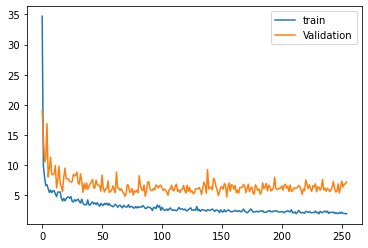

In [19]:
# evaluate the model
train_loss, train_acc = NN_model2.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = NN_model2.evaluate(X_test, Y_test, verbose=0)
print('Train loss: %.3f, Test loss: %.3f' % (train_loss, test_loss))
# plot training history
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [21]:
weights_file = 'fractal_dimension_2_2_with_min_max/Weights-155--4.74133.hdf5' # choose the best checkpoint 
NN_model2.load_weights(weights_file) # load it
NN_model2.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [22]:
Y_pred = NN_model2.predict(X_test)
#Y_pred=scaling_y.inverse_transform(Y_pred)

In [23]:
error= mean_absolute_percentage_error(Y_test, Y_pred, multioutput='raw_values')   
print('Mean absolute percentage error on test set: ', error)

Mean absolute percentage error on test set:  [0.04427016 0.07146601 0.054687  ]
